In [3]:
import scipy.io

import sys
realmin = sys.float_info.min

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
from statistics import NormalDist
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

In [16]:
def load_data(google_colab, data_section):
	if google_colab == True:
		from google.colab import drive
		drive.mount('/content/drive')

		filename = f"/content/drive/My Drive/KPI/KPI навчання/5-6 курс/Дипломне проектування/Article replication/Data/data_{data_section}.mat"
	else:
		filename = f"Data/data_{data_section}.mat"

	dataframe_mat = scipy.io.loadmat(filename)

	vote_rc = pd.DataFrame(
		data = dataframe_mat['V_rc'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
	)
	vote_rc = vote_rc.replace({-100: np.nan, -1: 0, 1: 1})

	party_leadership_position_rc = pd.DataFrame(
		data = dataframe_mat['party_leadership_position_rc'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc'][0]))] # 1st row as the column names
	)
	party_leadership_position_rc = party_leadership_position_rc.replace({0: np.nan})

	party_list = pd.DataFrame(
		data = dataframe_mat['party_list'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
	)

	congress_list = pd.DataFrame(
		data = dataframe_mat['congress_list'],
		index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
		columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
	)

	return vote_rc, party_leadership_position_rc, party_list, congress_list

In [38]:
def select_congress_data(congress_id, bills_per_congress, congress_id_involved, vote_rc, party_leadership_position_rc, party_list):
	beginning_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id))
	].sum()
	ending_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id) + 1)
	].sum()

	vote_congress = vote_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
	vote_congress_array = np.array(vote_congress)

	party_list_congress = party_list.loc[vote_congress.index]
	party_list_congress_array = np.array(party_list_congress).flatten()

	party_leadership_position_rc_congress = party_leadership_position_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
	party_leadership_position_rc_congress_array = np.array(party_leadership_position_rc_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	return N, T, vote_congress_array, party_list_congress_array, party_leadership_position_rc_congress_array

In [40]:
def set_initial_guess(N, T, party_list_congress_array):
	random.seed(112)

	theta = np.array([random.uniform(0,1) for _ in range(N)])

	# Normalize theta
	theta = theta - theta[0]

	if party_list_congress_array[0] == 100:
		# center Dems around 0 and GOP further right
		theta[1:] = [
			theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5
			for i in range(1,len(theta))
		]
	else:
		# center GOP around 0 and Dems further left
		theta[1:] = [
			theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5
			for i in range(1,len(theta))
		]

	# initialize ymax
	ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

	# initialize cutlines for bills
	m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

	# construct a big parameter vector
	omega_initial_guess = np.concatenate([theta, ymax, m])

	return omega_initial_guess

In [44]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [45]:
@njit
def norm_sf(x):
    # (1 - cdf) for the standard normal distribution
    return math.erfc(x / np.sqrt(2.0)) / 2.0

In [46]:
@njit
def neg_likelihood(omega, N, T, realmin, vote_congress_array, party_list_congress_array, party_leadership_position_rc_congress_array):
	# Unpack (decompose) parameter vector
	theta = np.zeros(N)
	ymax = np.zeros(2)
	m = np.zeros(T)

	for deputy in range(N):
		theta[deputy] = omega[deputy]

	ymax[0], ymax[1] = omega[0 + N], omega[1 + N]

	for bill in range(T):
		m[bill] = omega[N + 2 + bill]


	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		likelihood_pos, likelihood_neg = 0, 0
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)

			if party_leadership_position_rc_congress_array[deputy][bill] == -1.0:
				whip_party_pos = 1.0
				whip_party_neg = -1.0
			if party_leadership_position_rc_congress_array[deputy][bill] == 1.0:
				whip_party_pos = -1.0
				whip_party_neg = 1.0

			cdf_arg_pos = (
				m[bill] - theta[deputy] - whip_party_pos*ymax[party_id]
			)

			cdf_arg_neg = (
				m[bill] - theta[deputy] - whip_party_neg*ymax[party_id]
			)

			# use math.erf() to calculate cdf
			cdf_value_arg_pos = norm_cdf(cdf_arg_pos)
			sf_value_arg_pos = norm_sf(cdf_arg_pos)

			cdf_value_arg_neg = norm_cdf(cdf_arg_neg)
			sf_value_arg_neg = norm_sf(cdf_arg_neg)

			# avoid infinities
			indicator = cdf_value_arg_pos == 0
			cdf_value_arg_pos = indicator*realmin + (1-indicator)*cdf_value_arg_pos
			logcdf_value_arg_pos = np.log(cdf_value_arg_pos)

			indicator = sf_value_arg_pos == 0
			sf_value_arg_pos = indicator*realmin + (1-indicator)*sf_value_arg_pos
			logsf_value_arg_pos = np.log(sf_value_arg_pos)

			indicator = cdf_value_arg_neg == 0
			cdf_value_arg_neg = indicator*realmin + (1-indicator)*cdf_value_arg_neg
			logcdf_value_arg_neg = np.log(cdf_value_arg_neg)

			indicator = sf_value_arg_neg == 0
			sf_value_arg_neg = indicator*realmin + (1-indicator)*sf_value_arg_neg
			logsf_value_arg_neg = np.log(sf_value_arg_neg)

			# use scipy.stats.norm()
			# logcdf_value_arg_pos = scipy.stats.norm.logcdf(cdf_arg_pos)
			# logsf_value_arg_pos = scipy.stats.norm.logsf(cdf_arg_pos)

			# logcdf_value_arg_neg = scipy.stats.norm.logcdf(cdf_arg_neg)
			# logsf_value_arg_neg = scipy.stats.norm.logsf(cdf_arg_neg)

			likelihood_pos += vote_congress_array[deputy][bill] * logcdf_value_arg_pos + \
				(1 - vote_congress_array[deputy][bill]) * logsf_value_arg_pos
			likelihood_neg += vote_congress_array[deputy][bill] * logsf_value_arg_neg + \
				(1 - vote_congress_array[deputy][bill]) * logcdf_value_arg_neg

		likelihood_value += max(likelihood_pos,likelihood_neg)

	return -likelihood_value

In [17]:
data_section = "senate"
google_colab = False

vote_rc, party_leadership_position_rc, party_list, congress_list = load_data(google_colab, data_section)

In [32]:
print(f"{data_section.upper()} statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
print(f"\nNumber of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses, id: {np.min(congress_id)} - {np.max(congress_id)})")
print(f"Number of deputies overall = {party_list.size}")

SENATE statistics
----------------

Number of bills overall = 25824 (46 congresses, id: 70 - 115)
Number of deputies overall = 789


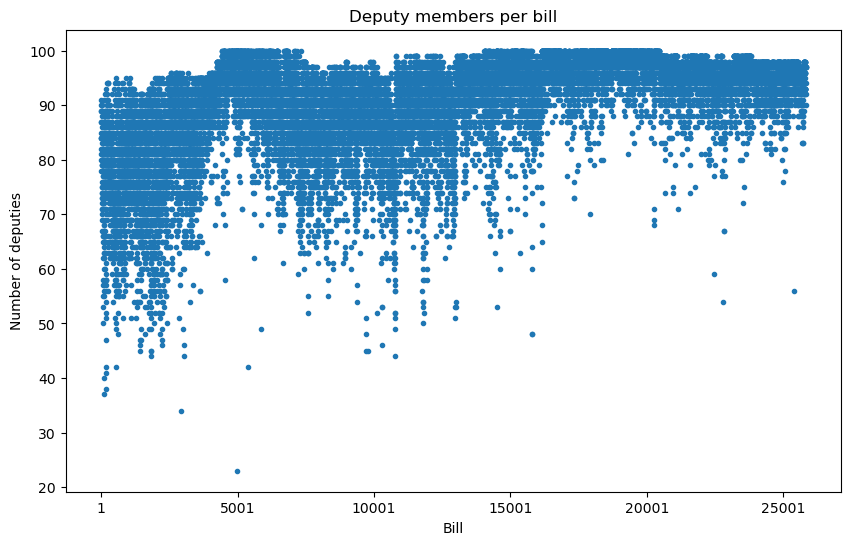

In [33]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

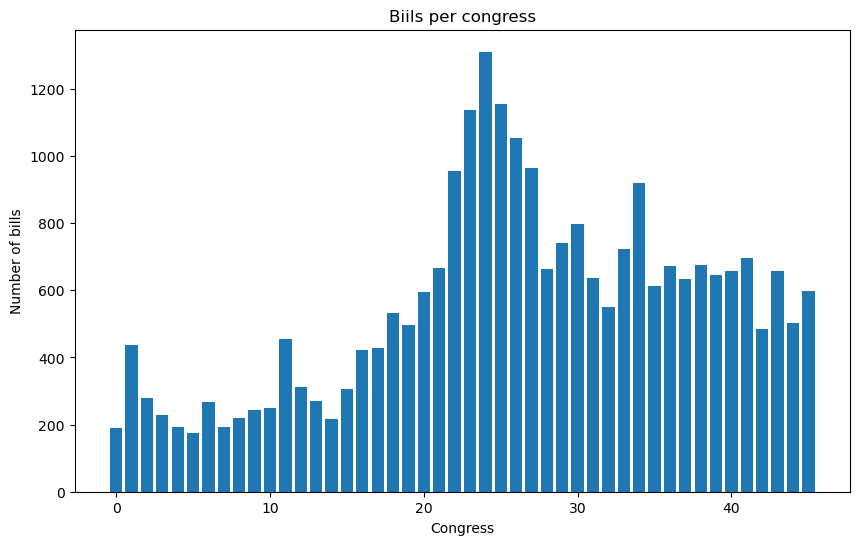

In [34]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

In [52]:
distance_between_party_centroids = np.zeros(len(congress_id))

for congress_id_involved in [70,71]:
	N, T, vote_congress_array, party_list_congress_array, party_leadership_position_rc_congress_array = select_congress_data(congress_id, bills_per_congress, congress_id_involved, vote_rc, party_leadership_position_rc, party_list)

	omega_initial_guess = set_initial_guess(N, T, party_list_congress_array)

	result = minimize(
		fun = neg_likelihood,
		x0 = omega_initial_guess,
		method = "SLSQP", # "SLSQP", "Nelder-Mead", "COBYLA"
		args = (N, T, realmin, vote_congress_array, party_list_congress_array, party_leadership_position_rc_congress_array),
		tol = 0.1,
		options = {"maxiter": 100000}
	)

	omega_hat = result.x
	theta_R = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
	R_party_centroid = np.mean(theta_R)

	theta_D = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
	D_party_centroid = np.mean(theta_D)

	distance_between_party_centroids[int(congress_id_involved - np.min(congress_id))] = np.abs(R_party_centroid - D_party_centroid)

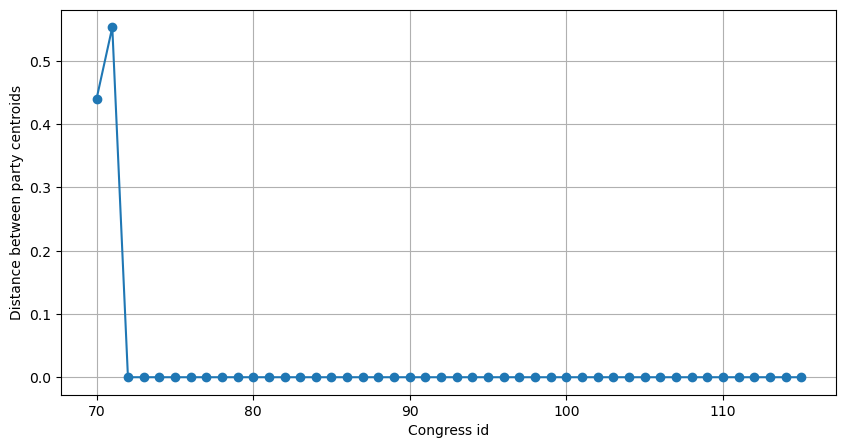

In [53]:
plt.figure(figsize=(10,5))
plt.plot(congress_id, distance_between_party_centroids, "o-")
plt.grid()
plt.xlabel(r"Congress id")
plt.ylabel(r"Distance between party centroids")
plt.show()